
#https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE?usp=sharing
#This is a link if you want to access a data in drive 
#https://susanqq.github.io/UTKFace/
#or used this link for download a dataset in your system.



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tarfile

tmp = tarfile.open('/content/drive/My Drive/UTKface_Aligned&cropped/UTKFace.tar.gz', "r:gz")
tmp.extractall()

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
DATA_DIR = "/UTKFace/"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'female': 1, 'male': 0},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'asian': 2, 'black': 1, 'indian': 3, 'others': 4, 'white': 0})

In [0]:

def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [0]:
os.chdir('UTKFace')
files = os.listdir()


In [0]:
attributes = list(map(parse_filepath, files))


39_1_20170116174525125.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
61_1_20170109150557335.jpg.chip.jpg


In [0]:
df = pd.DataFrame(attributes)
df.head()

,0,1,2
0,53.0,male,white
1,45.0,female,black
2,85.0,male,white
3,8.0,female,asian
4,27.0,female,indian


In [0]:
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,53.0,male,white,53_0_0_20170109012751966.jpg.chip.jpg
1,45.0,female,black,45_1_1_20170113005725568.jpg.chip.jpg
2,85.0,male,white,85_0_0_20170111205823547.jpg.chip.jpg
3,8.0,female,asian,8_1_2_20170109205424712.jpg.chip.jpg
4,27.0,female,indian,27_1_3_20170104223211159.jpg.chip.jpg


In [0]:
df.describe()


,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


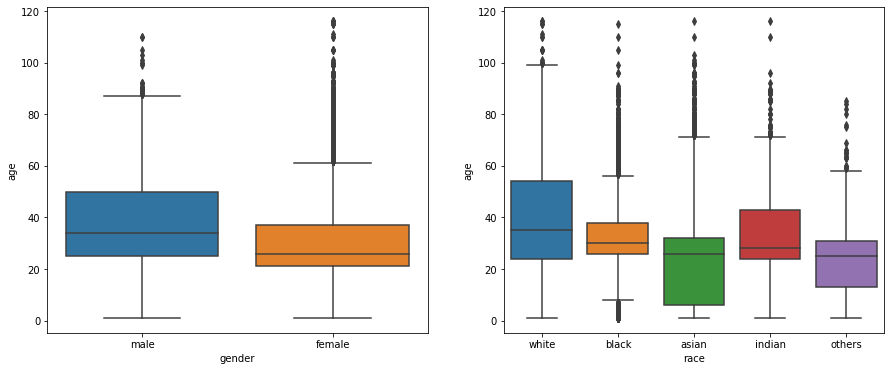

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

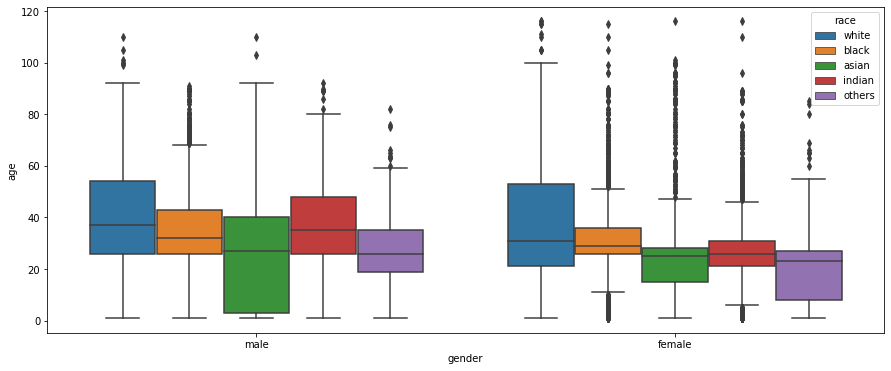

In [0]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

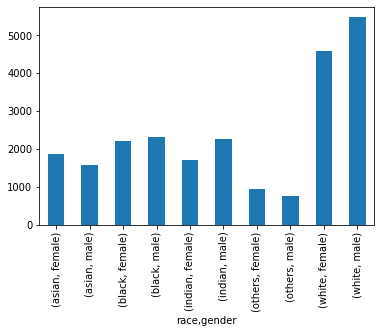

In [0]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')


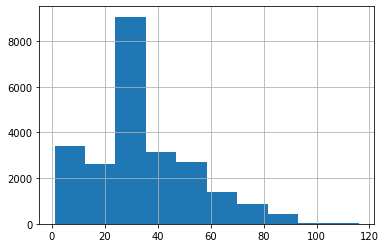

In [0]:
df['age'].hist()


In [0]:
df['age'].describe()


count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

In [0]:
df = df[(df['age'] > 10) & (df['age'] < 65)]


In [0]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(9079, 3891, 5559, 64.0)

In [0]:
from keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=2048):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [0]:
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.optimizers import SGD
from keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(_)

# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})
# model.summary()

In [0]:

batch_size = 16
valid_batch_size = 16
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)



history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=2,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/2
567/567 [==============================] - 110s 194ms/step - loss: 2.5272 - age_output_loss: 0.0502 - race_output_loss: 1.2607 - gender_output_loss: 0.5358 - age_output_mean_absolute_error: 0.1773 - race_output_acc: 0.5245 - gender_output_acc: 0.7575 - val_loss: 2.6865 - val_age_output_loss: 0.0600 - val_race_output_loss: 1.3987 - val_gender_output_loss: 0.4684 - val_age_output_mean_absolute_error: 0.1941 - val_race_output_acc: 0.4982 - val_gender_output_acc: 0.7783
Epoch 2/2
567/567 [==============================] - 105s 186ms/step - loss: 1.7600 - age_output_loss: 0.0323 - race_output_loss: 0.9157 - gender_output_loss: 0.3219 - age_output_mean_absolute_error: 0.1422 - race_output_acc: 0.6716 - gender_output_acc: 0.8642 - val_loss: 1.6586 - val_age_output_loss: 0.0297 - val_race_output_loss: 0.8554 - val_gender_output_loss: 0.3160 - val_age_output_mean_absolute_error: 0.1336 - val_race_output_acc: 0.6880 - val_gender_output_acc: 0.8585


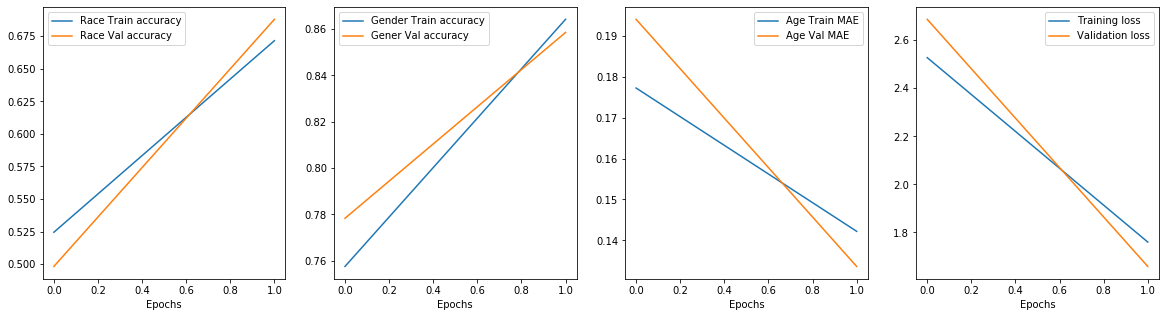

In [0]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_acc'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_acc'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_acc'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_acc'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_mean_absolute_error'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_mean_absolute_error'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [0]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{'age_output_loss': 0.03012942579076734,
 'age_output_mean_absolute_error': 0.13357833703589994,
 'gender_output_acc': 0.8680959302325582,
 'gender_output_loss': 0.3044327036585919,
 'loss': 1.6241517177847928,
 'race_output_acc': 0.7011264534883721,
 'race_output_loss': 0.8396401280580565}

In [0]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [0]:

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [0]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.85      0.67      0.75        52
           1       0.69      0.83      0.75        24
           2       0.43      0.60      0.50        10
           3       0.45      0.69      0.55        29
           4       0.00      0.00      0.00        13

    accuracy                           0.63       128
   macro avg       0.49      0.56      0.51       128
weighted avg       0.61      0.63      0.61       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.96      0.74      0.84        66
           1       0.78      0.97      0.86        62

    accuracy                           0.85       128
   macro avg       0.87      0.86      0.85       128
weighted avg       0.87      0.85      0.85       128



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


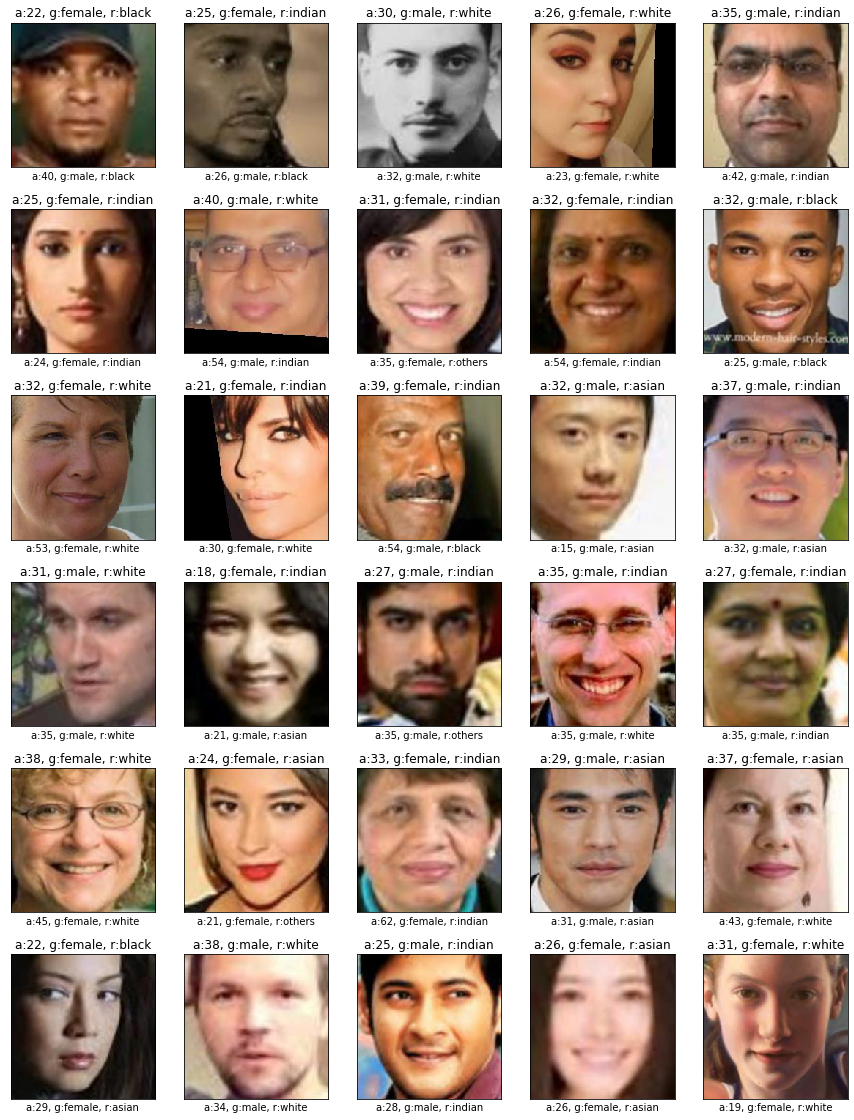

In [0]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(int(age_pred[img_idx]), ID_GENDER_MAP[gender_pred[img_idx]], ID_RACE_MAP[race_pred[img_idx]]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx]], ID_RACE_MAP[race_true[img_idx]]))
    ax.set_xticks([])
    ax.set_yticks([])